In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 연결망 그래프 한글 깨짐 현상 방지: 안되면 run time 재시작하면 됨

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (6,904 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121913 files and dire

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

plt.plot([1,2,3],[1,2,3])
plt.title('한글 보임')   # 런타임 다시 시작하면 한글 정상 작동

# 의미연결망분석(Semantic Network Analysis)
### 참조: https://chasingdreams.tistory.com/40

* 사회연결망분석(Social Network Analysis): 분석 대상 간의 관계를 연결망 구조로 표현하고 중심성 등 관계 수치를 분석하는 기법. 친구 관계, 상품 판매, 전력 공급 등에서 행위자 간 관계 분석.
* 의미연결망분석(Semantic Network Analysis): 텍스트 내 단어의 관계에 사회연결망 분석 기법을 적용한 것. 일정한 범위(대체로 문장) 내에서 공동으로 출현한 단어(명사)를 서로 연결된 것으로 간주하고 그 관계를 분석.


### 데이터 불러오기: 형태소 분석으로 단어(명사)가 추출된 데이터

In [ ]:
import pandas as pd

df=pd.read_excel('/content/drive/MyDrive/2024_1_class/경희대맛집_블로그_명사추출.xlsx')
df=pd.read_excel('/content/drive/MyDrive/2024_1_class/100분토론_제목명사_040123.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1030 non-null   int64  
 1   정권구분     1030 non-null   int64  
 2   회차       1030 non-null   float64
 3   연도       1030 non-null   int64  
 4   날짜       1030 non-null   object 
 5   사회자      1030 non-null   object 
 6   제목       1030 non-null   object 
 7   출연자      1020 non-null   object 
 8   제목_명사    1028 non-null   object 
 9   제목_주요품사  1029 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 80.6+ KB


### 단어별 빈도 분석

In [ ]:
from collections import Counter

nouns=list(df['출연자'].dropna())
nouns=','.join(nouns).split(',')
nouns_count=Counter(nouns).most_common()    # 빈도 수 많은 순으로 단어와 빈도 리스트 출력
len(nouns_count)

# 빈도 수 높은 키워드(100개 안팎) 추출
noun100_limit=nouns_count[:100][-1][1]         # 순위 100위에 해당하는 단어의 빈도

nouns_key=[(n,i) for n,i in nouns_count if i>=noun100_limit]  # 빈도 수가 많지 않은 데이터라면, 1 또는 2로 대체해 대부분 단어 포함시키기
print('키워드: 빈도 {}회 이상'.format(str(noun100_limit)))
print('키워드 수: ' +str(len(nouns_key)))    # 최종 키워드 단어 수 체크. 100개 안팎으로.

키워드: 빈도 8회 이상
키워드 수: 115


## 공동출현 단어 추출과 빈도 분석

* 공동출현(co-occurrence): 단어 두 개가 일정한 범위나 거리 내(대체로 문장)에서 함께 출현. window=지정 범위.

In [ ]:
# 공동출현 단어 추출 함수화

def cooccurence(nouns_lst):
    noun_pairs=[[(j,i) for i in nouns_lst  if i != j] for j in nouns_lst]
    noun_pairs1=sum(noun_pairs,[])
    noun_pairs2=set(tuple(sorted(pair)) for pair in noun_pairs1)           # sort 통해 중복 단어쌍 하나로 수정
    #noun_pairs3=[p for i, p in enumerate(noun_pairs2) if p not in noun_pairs2[:i]]
    return list(noun_pairs2)

# 연습
cooccurence(nouns_lst=['뷔','제이홉','지민', '진'])

In [ ]:
# 데이터에서 공동출현 단어 추출: 키워드 대상
nouns_key_lst=[n for n,i in nouns_key]
noun_key_pairs_all=[]
for nouns in df['출연자'].dropna():
    nouns_lst=nouns.split(',')
    nouns_lst=[n for n in nouns_lst if n in nouns_key_lst]
    noun_pairs=cooccurence(nouns_lst)
    noun_key_pairs_all.append(noun_pairs)

noun_key_pairs_all=sum(noun_key_pairs_all,[])
len(noun_key_pairs_all)

### 단어 공동출현 매트릭스 만들기

In [ ]:
# 단어 공동출현 매트릭스 만들기 함수화
import numpy as np
import pandas as pd

def cooccur_matrix(noun_pairs_lst):
    n_lst=sorted(set(sum(noun_pairs_lst, ())))                # 단어 리스트
    n_dct=dict([(n,i) for i, n in enumerate(n_lst)])
    n_matrix = np.zeros((len(n_lst),len(n_lst)), dtype=int)   # 단어 인접행렬
    for i, j in noun_pairs_lst:
        n_matrix[n_dct[i]][n_dct[j]]+=1
    df_freq=pd.DataFrame(n_matrix, columns=n_lst, index=n_lst) # 단어 인접행렬 표
    print('단어: '+str(len(n_lst))+'개')
    return n_lst, n_matrix, df_freq

# 연습
noun_pairs_lst=[('뷔','제이홉'),('뷔','지민'),('지민','진'),('뷔','지민'),('제이홉','지민')]
result=cooccur_matrix(noun_pairs_lst)
result[2]     # 보통 undirected 인접행렬은 대각선을 기준으로 같은 숫자로 구성. 그러나 networkx에서는 undirected이면 행렬의 우상반을 읽음.

### 연결망그래프 만들기: 인접행렬 이용

* 공동출현 행렬(데이터프레임)은 인접행렬로 간주할 수 있음
* networkx 사용해 해당 행렬을 그래프로 시각화

In [ ]:
import networkx as nx

results=cooccur_matrix(noun_key_pairs_all)

G = nx.from_pandas_adjacency(results[2])   # 공동출현 행렬(데이터프레임)으로부터 연결망 만들기. undirected인 경우 매트릭스의 우상반을 읽음. directed인 경우에는 인자로 create_using=nx.DiGraph()추가. 그러면 매트릭스 전체를 읽음.
print(G.nodes())      # 노드 출력
len(G.nodes())
print(G.edges())      # 에지 출력
len(G.edges())
weights = nx.get_edge_attributes(G,'weight').values()    # 가중치 행렬이므로 edge weight 추출. 확인: len(weights)

### 중심성 수치 추출


*   각 중심성 계산 방법은 맨 아래 설명 참조. dc(degree_centrality) 주로 사용.


In [ ]:
dc = nx.degree_centrality(G)
# ec = nx.eigenvector_centrality(G, weight='weight')
# cc = nx.closeness_centrality(G, distance='weight')
# bc = nx.betweenness_centrality(G)
# pr = nx.pagerank(G)

### community 추출: modulairity 바탕으로

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

community = greedy_modularity_communities(G)

comm_dct={}                           # 전체 노드에 대해 community 부여
for c, nn in enumerate(community):
    for n in list(nn):
        comm_dct[n]=c

print('커뮤니티: '+str(set(comm_dct.values())))              # 0부터 시작
comm=dict([(n,comm_dct[n]) for n in G.nodes])   # 노드 순서대로 community 정보 소팅
df_comm=pd.DataFrame({'단어':comm.keys(), '커뮤니티':comm.values()})
print(df_comm)

### 연결망 시각화: 노드 크기 = 연결중심성, 에지 크기=weight

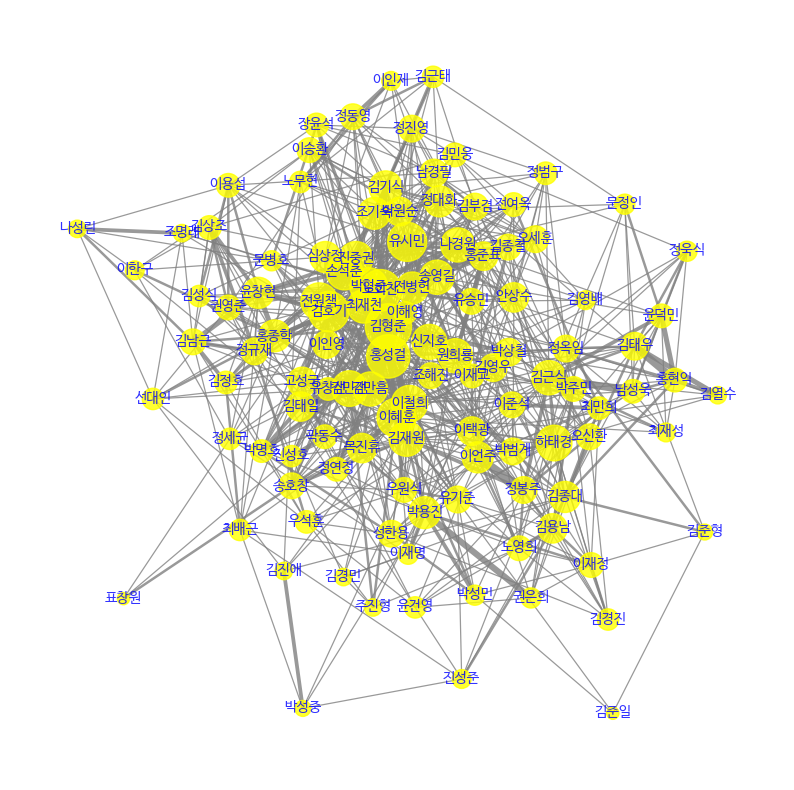

In [ ]:
import matplotlib.pyplot as plt

node_size_weight, width_weight = 3, 0.9

option = {
    'font_size' : 10,
    'font_color' : 'blue',
    'font_family' : 'NanumBarunGothic',
    'node_color' : 'yellow',
    'node_size' : [node_size_weight*1000*d for d in dc.values()],
    'edge_color' : 'grey',
    'width': [width_weight*w for w in weights],                 #list(weights),
    'alpha' : 0.8,
    'cmap' : plt.cm.autumn,  #Blues:
    'with_labels': True,
    'pos' : nx.spring_layout(G) #nx.kamada_kawai_layout(G) # 다른 레이아웃 종류는 아래 참조.
}

plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx(G, **option)

### 연결망 시각화: 노드 크기=연결중심성, 에지 크기=weight, 노드 색깔=community(modularity 기반)

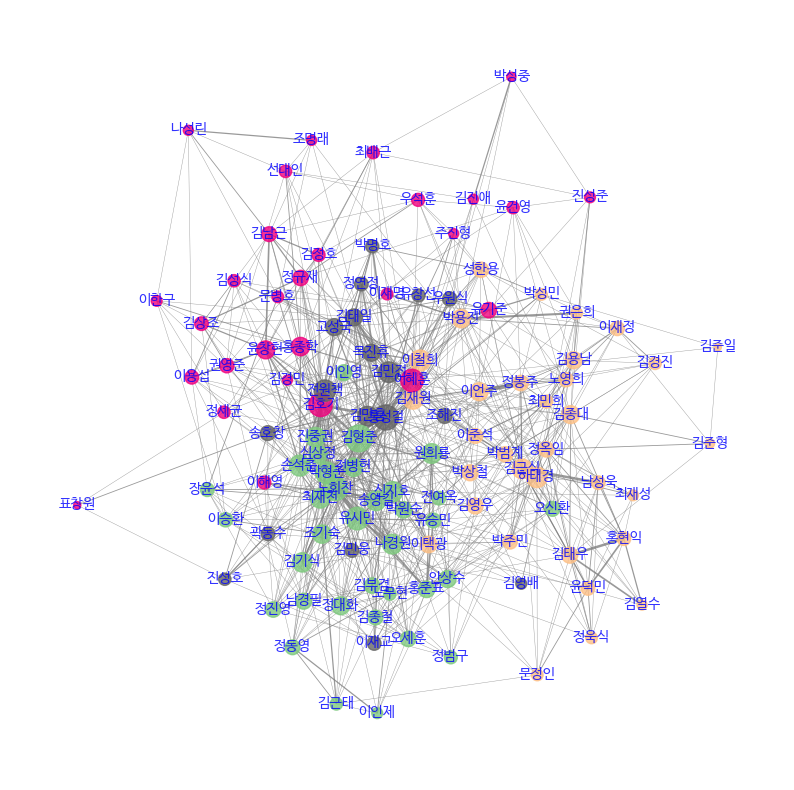

In [ ]:
import matplotlib.pyplot as plt

node_size_weight, width_weight = 1, 0.3

option = {
    'font_size' : 10,
    'font_color' : 'blue',
    'font_family' : 'NanumBarunGothic',
    'node_color' : list(comm.values()),    # modularity 기반 commumity 시각화
    'node_size' : [node_size_weight*1000*d for d in dc.values()],
    'edge_color' : 'grey',
    'width': [width_weight*w for w in weights],
    'alpha' : 0.8,
    'cmap' : plt.cm.Accent,  #Blues,
    'with_labels': True,
    'pos' :  nx.spring_layout(G) # nx.kamada_kawai_layout(G) #
}

plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx(G, **option)

### 분석 결과 데이터로 정리: 단어 빈도, 단어 연결중심성, 단어의 소속 커뮤니티

In [ ]:
print('상위 30위 키워드 빈도: ')
print(nouns_key[:30])    # pd.DataFrame(nouns_key[:30], columns=['상위 30위 키워드','빈도'])

dc_sorted=sorted(dc.items(), key=lambda x: x[1], reverse=True)
dc_sorted=[(n, round(d, 3)) for n,d in dc_sorted]
print('\n상위 30위 키워드 연결중심성: ')
print(dc_sorted[:30]) # pd.DataFrame(dc_sorted[:30], columns=['상위 30위 키워드','연결중심성'])

comm_sorted=sorted(comm.items(), key=lambda x: x[1], reverse=False)
print('\n단어의 소속 커뮤니티(modularity 기반): ')
print(comm_sorted[:30])

# 데이터프레임으로 모아서 정리(빈도 기준)
key_dc=pd.merge(pd.DataFrame(nouns_key), pd.DataFrame(dc_sorted), on=0, how='left') # 0 = 키워드
key_dc_comm=pd.merge(pd.DataFrame(key_dc), pd.DataFrame(comm_sorted), on=0, how='left')
key_dc_comm.columns=['단어', '빈도', '연결중심성','커뮤니티']
key_dc_comm

상위 30위 키워드 빈도: 
[('홍성걸', 42), ('김형준', 35), ('노회찬', 32), ('김호기', 29), ('홍준표', 27), ('유시민', 26), ('김근식', 24), ('진중권', 21), ('김재원', 20), ('전원책', 20), ('박용진', 20), ('김민전', 19), ('박형준', 19), ('윤창현', 19), ('이혜훈', 19), ('김만흠', 19), ('이철희', 19), ('손석춘', 18), ('홍종학', 18), ('송영길', 18), ('전병헌', 18), ('김태우', 18), ('신지호', 17), ('최재천', 17), ('나경원', 17), ('원희룡', 16), ('정대화', 16), ('김태일', 16), ('심상정', 16), ('김종대', 16)]

상위 30위 키워드 연결중심성: 
[('김형준', 0.368), ('홍성걸', 0.325), ('노회찬', 0.298), ('김호기', 0.281), ('유시민', 0.263), ('이혜훈', 0.263), ('박형준', 0.246), ('전원책', 0.237), ('손석춘', 0.228), ('이철희', 0.228), ('김민전', 0.219), ('하태경', 0.219), ('김재원', 0.211), ('신지호', 0.211), ('김근식', 0.202), ('김만흠', 0.202), ('나경원', 0.202), ('송영길', 0.202), ('원희룡', 0.202), ('진중권', 0.202), ('김기식', 0.193), ('최재천', 0.193), ('박용진', 0.175), ('전병헌', 0.175), ('조기숙', 0.175), ('홍종학', 0.175), ('김종대', 0.167), ('심상정', 0.167), ('윤창현', 0.167), ('이언주', 0.167)]

단어의 소속 커뮤니티(modularity 기반): 
[('김근태', 0), ('김기식', 0), ('김부겸', 0), ('김종철', 0), ('김형준', 0), (

,단어,빈도,연결중심성,커뮤니티
0,홍성걸,42,0.325,3
1,김형준,35,0.368,0
2,노회찬,32,0.298,0
3,김호기,29,0.281,2
4,홍준표,27,0.140,0
...,...,...,...,...
110,목진휴,8,0.149,3
111,박명호,8,0.088,3
112,진성준,8,0.061,2
113,오신환,8,0.114,0



## <참고> 레이아웃 종류

* pl = nx.planar_layout(G)
* frl = nx.fruchterman_reingold_layout(G)
* sl = nx.spectral_layout(G)
* rl = nx.random_layout(G)
* shl = nx.shell_layout(G)
* bl = nx.bipartite_layout(G, G.nodes())
* cl = nx.circular_layout(G)
* spl = nx.spring_layout(G)
* kkl = nx.kamada_kawai_layout(G)

## <참고> 중심성(Centrality) 지수

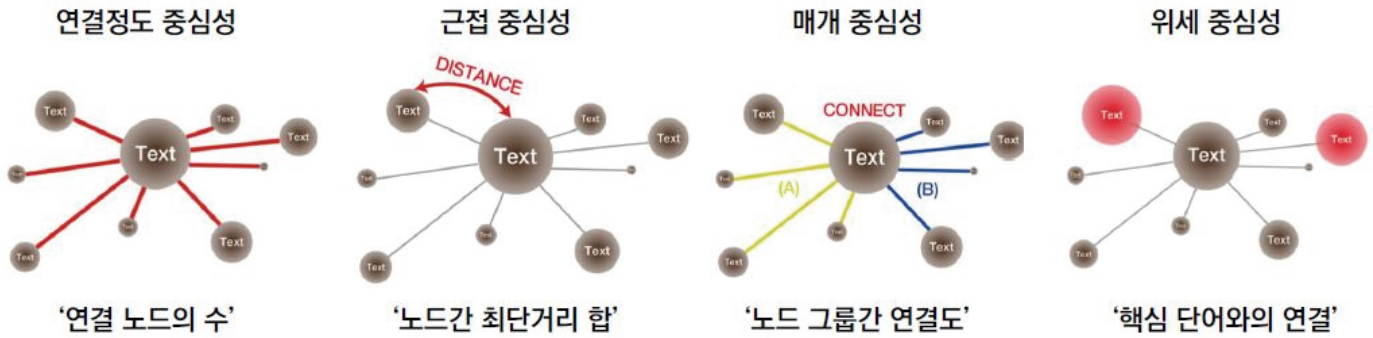

                                          (박상훈 & 이희정, 2019, 45쪽)

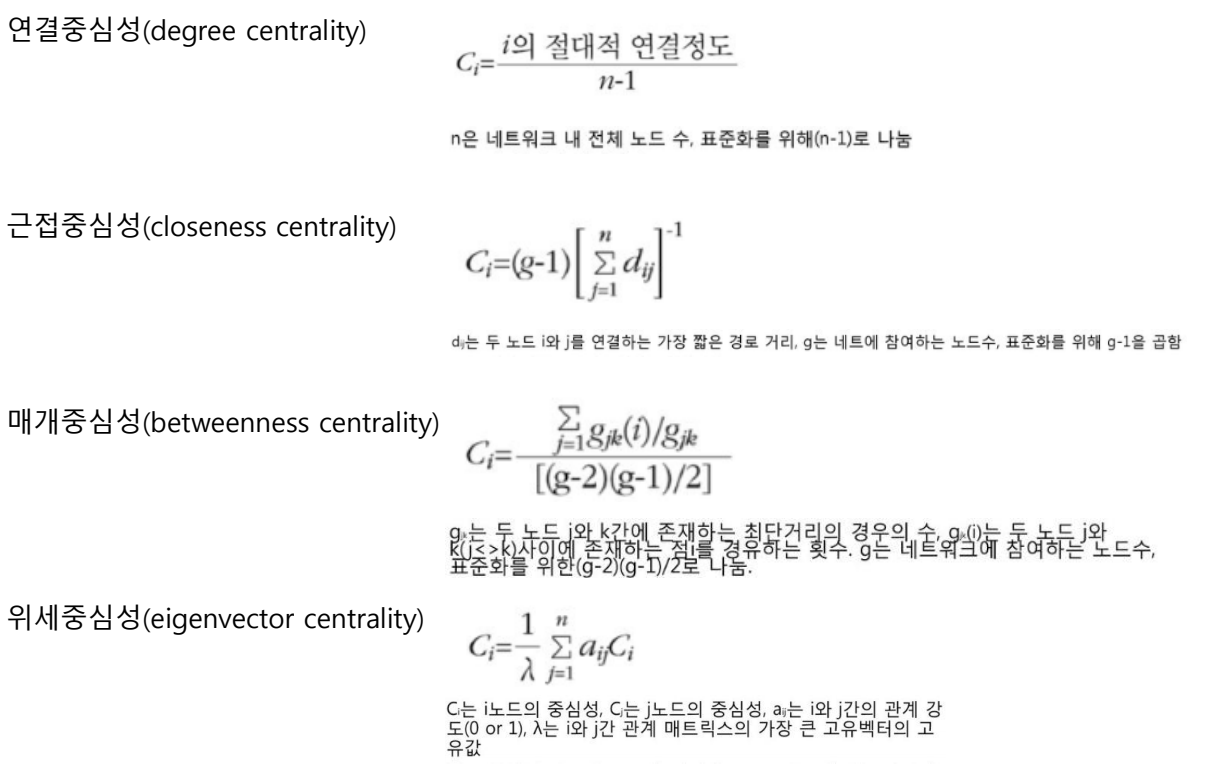

## <참고> 모듈성(modulairty)

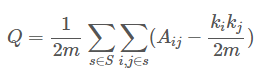





*방향이 없는 그래프 기준(https://jimmy-ai.tistory.com/15)

Q = Modularity를 의미하며, -1 ~ 1 사이의 값을 가지며, 높은 숫자일수록 그래프가 잘 분할되었다는 의미.  
  0.3~0.7 이상으로 측정되는 경우 커뮤니티 구조가 어느정도 뚜렷하게 나눠짐을 의미.

S = 분할된 그래프

Aij =분할된 그래프 내부에서 i번쨰 node와 j번째 node 사이에 edge 유무. 있으면 1, 없으면 0입니다.

m = 전체 edge의 개수

ki, kj = 전체 그래프에서 i번째, j번째 node의 degree

Aij−(kikj/2m) = 분할된 그래프 내부에 실제로 연결된 edge의 개수 - 그룹 내 edge 개수의 기대값을 의미

